# Mathematical Underpinnings - Lab 4

In [1]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import pandas as pd

## Task 1

### a)

#### bp 1)

In [ ]:
# a heatmap
# you may use pcolormesh function and draw a heatmap for a sample
# or draw a heatmap for a teoretic density function

# I give you an answer to that task, because it may take too much time to do it during labs.

In [21]:
def plot_xyz(data_2d, nbins=300):
    x = data_2d[:,0]
    y = data_2d[:,1]
    k = gaussian_kde(data_2d.T)
    xi, yi = np.mgrid[x.min(): x.max(): nbins*1j, y.min(): y.max(): nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi, yi, zi

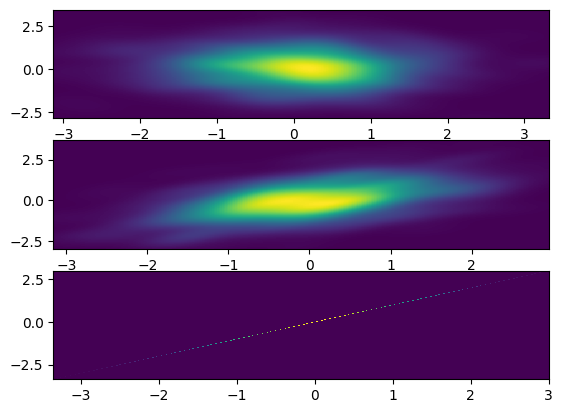

In [37]:
fig, axs = plt.subplots(3)

n = 1000
rpho = 0

data_0 = np.random.multivariate_normal(
    np.zeros(2),
    np.array([
        [1, rpho],
        [rpho, 1]
    ]),
    n
)
xi_0, yi_0, zi_0 = plot_xyz(data_0)

rpho = 0.5
data_1 = np.random.multivariate_normal(
    np.zeros(2),
    np.array([
        [1, rpho],
        [rpho, 1]
    ]),
    n
)
xi_1, yi_1, zi_1 = plot_xyz(data_1)

rpho = 1 - 1e-5  # make it very close to one
data_2 = np.random.multivariate_normal(
    np.zeros(2),
    np.array([
        [1, rpho],
        [rpho, 1]
    ]),
    n
)
xi_2, yi_2, zi_2 = plot_xyz(data_2)

# Make the plot
axs[0].pcolormesh(xi_0, yi_0, zi_0.reshape(xi_0.shape), shading='auto')
axs[1].pcolormesh(xi_1, yi_1, zi_1.reshape(xi_1.shape), shading='auto')
axs[2].pcolormesh(xi_2, yi_2, zi_2.reshape(xi_2.shape), shading='auto')
plt.show()

#### bp 2)

In [137]:
# tried to implement entropy and conditional entropy
# but values to different from official implementaion
# and not correlate that well...

def _count_probas(labels):
    return {
        x: (labels == x).sum() / labels.shape[0]
        for x in np.unique(labels)
    }

def _entropy(labels):
    p = _count_probas(labels)
    return -sum([p[x]*np.log(p[x]) for x in labels])

def _cond_entropy(labels, given):
    data = np.stack([labels, given]).T
    p = _count_probas(given)
    p.update({
        (x, y): ((labels == x) & (given == y)).sum() / data.shape[0]
        for x, y in set([(x,y) for x,y in data])
    })
    return -sum([p[x,y]*np.log(p[x,y]/p[y]) for x, y in data])

In [136]:
from sklearn.metrics import mutual_info_score

for data in [data_0, data_1, data_2]:
    x, y = data.T
    x_labels = np.asarray(pd.cut(x, bins=10, labels=list(range(1,11))))
    y_labels = np.asarray(pd.cut(y, bins=10, labels=list(range(1,11))))
    print()
    print(pearsonr(x, y))
    print('mutual_info_score:', mutual_info_score(x_labels, y_labels))
    # print(
    #     'mutual_info_score (my implementation):',
    #     _entropy(x_labels) - _cond_entropy(x_labels, given=y_labels)
    # )


PearsonRResult(statistic=-0.0362231941914346, pvalue=0.2524491307043185)
mutual_info_score: 0.04276217349624892
mutual_info_score (my implementation): 237.46960989536726

PearsonRResult(statistic=0.5160705931163014, pvalue=3.746156856967814e-69)
mutual_info_score: 0.1789827053316195
mutual_info_score (my implementation): 227.05308873469934

PearsonRResult(statistic=0.9999910877887266, pvalue=0.0)
mutual_info_score: 1.8712638966919806
mutual_info_score (my implementation): 284.86456082134725


#### bp 3)

In [173]:
n = 1000
N = 100

rhos = []
corrs = []
MIs = []
for rho in np.linspace(0, 1, 10):
    for j in range(N):
        rhos.append(rho)
        x, y = np.random.multivariate_normal(np.zeros(2), np.array([[1, rho], [rho, 1]]), n).T
        corr, *_ = pearsonr(x, y)
        corrs.append(corr)
        x_labels = np.asarray(pd.cut(x, bins=10, labels=list(range(1,11))))
        y_labels = np.asarray(pd.cut(y, bins=10, labels=list(range(1,11))))
        MIs.append(mutual_info_score(x_labels, y_labels))
        # MIs.append(
        #     _entropy(x_labels) - _cond_entropy(x_labels, given=y_labels)
        # )

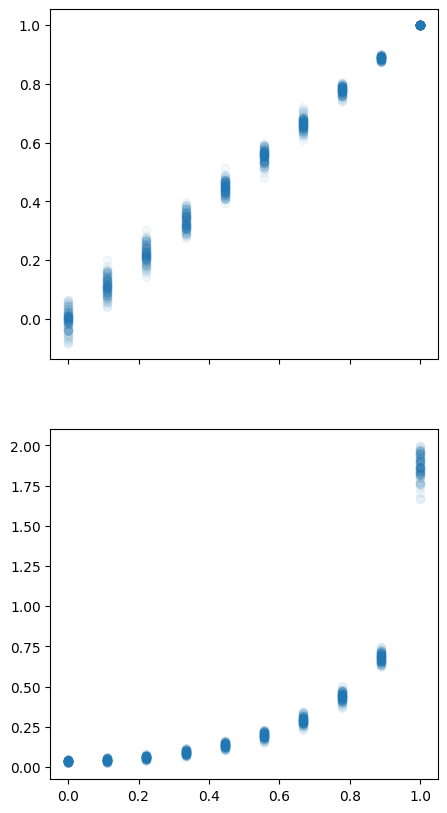

In [187]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 10))
ax[0].scatter(rhos, corrs, alpha=0.05, color='C0')
ax[1].scatter(rhos, MIs, alpha=0.05, color='C0')
plt.show()

#### bp 4)

A hint: note that mutual information between two correlated normal distributions i.e. when $(X, Y)\sim \mathcal{N}((0,0)', \Sigma)$ and
$$\Sigma = \begin{pmatrix}
        \sigma_x^2 & \rho \\ \rho & \sigma_y^2
    \end{pmatrix}$$
equals
$$I(X,Y) = \frac{1}{2}\log \left(\frac{\sigma_x^2\sigma_y^2}{\sigma_x^2\sigma_y^2 - \rho^2}\right).$$

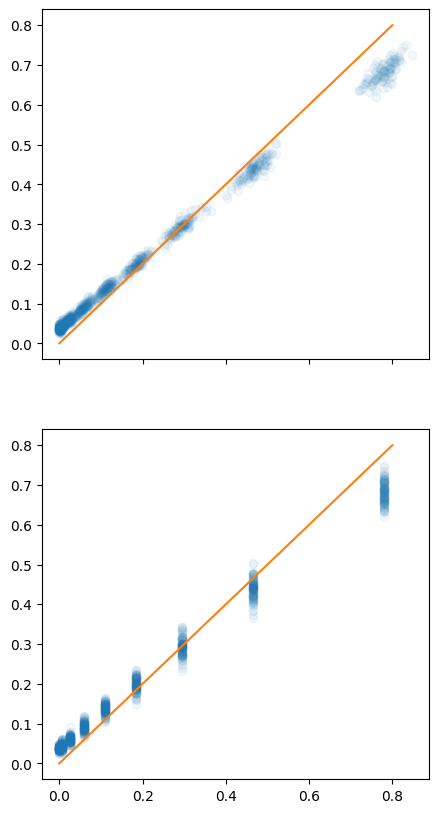

In [186]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 10))

# hide exponentially growing part
corrs_ = corrs[:-100]
rhos_ = rhos[:-100]
MIs_ = MIs[:-100]

xs = [-np.log(1-c**2)/2 for c in corrs_]
ax[0].scatter(xs, MIs_, alpha=0.05, color='C0')
ax[0].plot([0, 0.8], [0, 0.8], color='C1')

xs = [-np.log(1-r**2)/2 for r in rhos_]
ax[1].scatter(xs, MIs_, alpha=0.05, color='C0')
ax[1].plot([0, 0.8], [0, 0.8], color='C1')
plt.show()

### b)

#### bp 1)

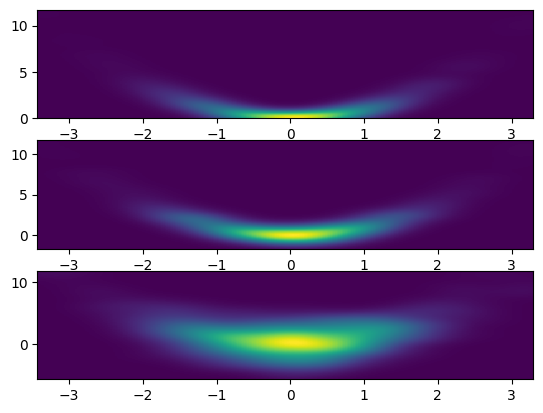

In [32]:
fig, axs = plt.subplots(3)

n = 1000
x = np.random.normal(0, 1, n)

data_2d = np.array([x, x**2 + np.random.normal(0, 0, n)]).T
xi_0, yi_0, zi_0 = plot_xyz(data_2d)
data_2d = np.array([x, x**2 + np.random.normal(0, 0.5, n)]).T
xi_1, yi_1, zi_1 = plot_xyz(data_2d)
data_2d = np.array([x, x**2 + np.random.normal(0, 2, n)]).T
xi_2, yi_2, zi_2 = plot_xyz(data_2d)

# Make the plot
axs[0].pcolormesh(xi_0, yi_0, zi_0.reshape(xi_0.shape), shading='auto')
axs[1].pcolormesh(xi_1, yi_1, zi_1.reshape(xi_1.shape), shading='auto')
axs[2].pcolormesh(xi_2, yi_2, zi_2.reshape(xi_2.shape), shading='auto')
plt.show()

#### bp 2) and 3)

In [191]:
n = 1000
N = 100

epsilons = []
corrs = []
MIs = []
for eps in np.linspace(0, 1, 10):
    for j in range(N):
        epsilons.append(eps)
        x = np.random.normal(0, 1, n)
        y = x**2 + np.random.normal(0, eps, n)
        corr, *_ = pearsonr(x, y)
        corrs.append(corr)
        x_labels = np.asarray(pd.cut(x, bins=10, labels=list(range(1,11))))
        y_labels = np.asarray(pd.cut(y, bins=10, labels=list(range(1,11))))
        MIs.append(mutual_info_score(x_labels, y_labels))

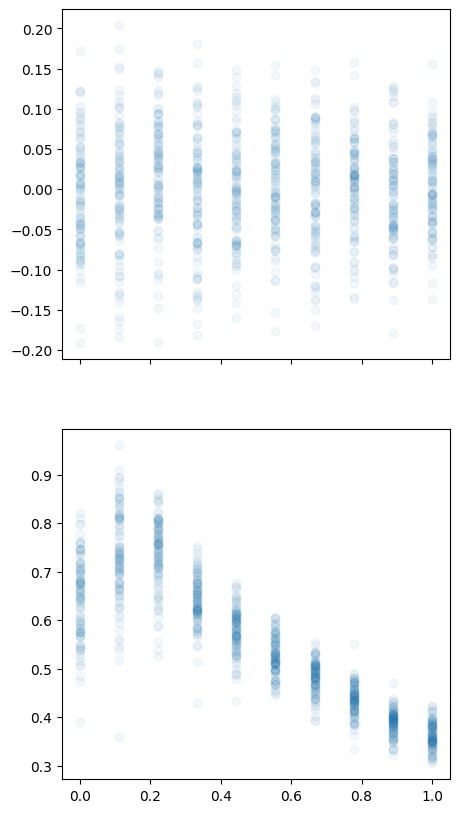

In [192]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 10))
ax[0].scatter(rhos, corrs, alpha=0.05, color='C0')
ax[1].scatter(rhos, MIs, alpha=0.05, color='C0')
plt.show()

<ipython-input-189-931f666bf01b>:8: RuntimeWarning: divide by zero encountered in log
  xs = [-np.log(1-c**2)/2 for c in corrs_]


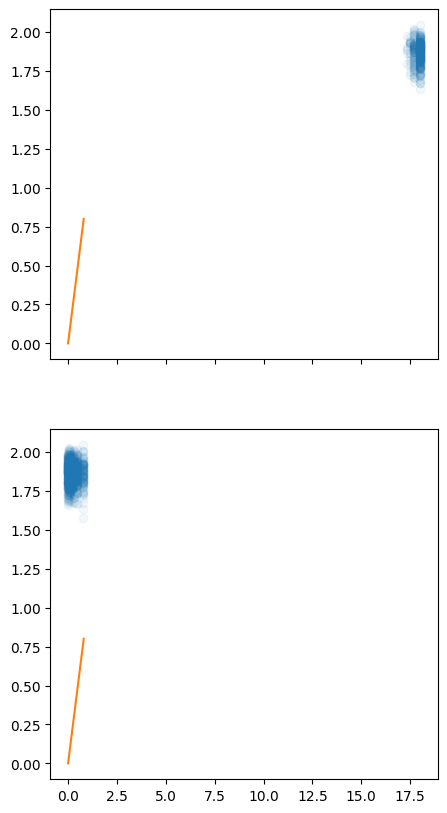

In [189]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 10))

# hide exponentially growing part
corrs_ = corrs[:-100]
rhos_ = rhos[:-100]
MIs_ = MIs[:-100]

xs = [-np.log(1-c**2)/2 for c in corrs_]
ax[0].scatter(xs, MIs_, alpha=0.05, color='C0')
ax[0].plot([0, 0.8], [0, 0.8], color='C1')

xs = [-np.log(1-r**2)/2 for r in rhos_]
ax[1].scatter(xs, MIs_, alpha=0.05, color='C0')
ax[1].plot([0, 0.8], [0, 0.8], color='C1')
plt.show()

## Task 2

### a)

In [194]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def asymptotic_indep_test(x, y, stats, bins=10):
    x_labels = np.asarray(pd.cut(x, bins=10, labels=list(range(1,11))))
    y_labels = np.asarray(pd.cut(y, bins=10, labels=list(range(1,11))))
    if stats == 'mi':
        mi_estimate = mutual_info_score(x_labels, y_labels)
        test_stat_value = mi_estimate*2*(x.size)
        df = (bins-1)**2
        p_value = 1 - chi2.cdf(test_stat_value, df)
    elif stats=='chi2':
        contingency_table = np.histogram2d(x_labels, y_labels, bins=[list(range(1, bins+1)), list(range(1, bins+1))])
        test_stat_value, p_value, _, _ = chi2_contingency(contingency_table[0])
    return test_stat_value, p_value

### b)

In [193]:
def permutation_test(x, y, B, bins=10):
    x_labels = np.asarray(pd.cut(x, bins=10, labels=list(range(1,11))))
    y_labels = np.asarray(pd.cut(y, bins=10, labels=list(range(1,11))))
    mi_base = mutual_info_score(x_labels, y_labels)
    numerator = 1
    denominator = 1 + B
    for permutation in range(B):
        x_permuted = np.random.permutation(x_labels)
        mi_permuted = mutual_info_score(x_permuted, y_labels)
        if mi_base <= mi_permuted:
            numerator += 1
    p_value = numerator/denominator
    return mi_base, p_value

### c)

In [198]:
# data with rho = 0.5
x, y = data_1.T
asymptotic_indep_test(x, y, "mi")

(357.965410663239, 0.0)

In [199]:
asymptotic_indep_test(x, y, "chi2")

(441.02388389399846, 1.0707288889995386e-57)

In [202]:
permutation_test(x, y, 100)
# we correctly reject the null hypothesis (if to assume significance level 0.01)

(0.1789827053316195, 0.009900990099009901)